In [352]:
import ast
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

audio_df = pd.read_csv(
    '../data/files/audio_classification_3sec_deep_32.csv',
    converters={2: ast.literal_eval}
)

audio_df = audio_df.set_axis(['clip_id', 'genre', 'features', 'isAugmented'], axis=1)

records = []
for _, row in audio_df.iterrows():
    clip = row['clip_id']
    is_aug = row['isAugmented']
    genre  = row['genre']
    for seg_id, feat_vec in enumerate(row['features']):
        rec = {
            'clip_id':     clip,
            'isAugmented': is_aug,
            'segment_id':  seg_id,
            'genre':       genre
        }
        for i, v in enumerate(feat_vec):
            rec[f'feat_{i}'] = v
        records.append(rec)

seg_df = pd.DataFrame(records)
le = LabelEncoder()
seg_df['genre_idx'] = le.fit_transform(seg_df['genre'])

real_clips = audio_df[audio_df.isAugmented == 0]

train_clips_old, test_clips = train_test_split(
    real_clips, test_size=0.1, random_state=42,
    stratify=real_clips['genre'], shuffle=True
)

train_clips, valid_clips = train_test_split(train_clips_old, test_size=0.05, random_state=42, stratify=train_clips_old['genre'])

train_ids = train_clips['clip_id'].tolist()
test_ids = test_clips['clip_id'].tolist()
valid_ids = valid_clips['clip_id'].tolist()

train_ids_full = []
valid_ids_full = []

for id in train_ids:
    train_ids_full.append(id)
    train_ids_full.append(id+1)
    train_ids_full.append(id+2)
    
for id in valid_ids:
    valid_ids_full.append(id)

train_df = seg_df[seg_df.clip_id.isin(train_ids_full)] # real + augmented
valid_df = seg_df[seg_df.clip_id.isin(valid_ids_full)] # real + augmented
test_df  = seg_df[seg_df.clip_id.isin(test_ids)] # only real

feature_cols = [c for c in seg_df.columns if c.startswith('feat_')] + ['isAugmented']
X_train = train_df[feature_cols]
y_train = train_df['genre_idx']

X_valid = valid_df[feature_cols]
y_valid = valid_df['genre_idx']

X_test  = test_df[feature_cols]
y_test_segments = test_df['genre_idx']

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

In [353]:
# 6) TRAIN XGBoost
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=1,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    device='cuda',
    n_jobs=-1,
    early_stopping_rounds=20
)
clf.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_valid_scaled, y_valid)], verbose=True)

[0]	validation_0-mlogloss:2.24212	validation_1-mlogloss:2.23825
[1]	validation_0-mlogloss:2.19354	validation_1-mlogloss:2.18712
[2]	validation_0-mlogloss:2.15140	validation_1-mlogloss:2.14397
[3]	validation_0-mlogloss:2.11353	validation_1-mlogloss:2.11609
[4]	validation_0-mlogloss:2.07937	validation_1-mlogloss:2.08470
[5]	validation_0-mlogloss:2.04818	validation_1-mlogloss:2.06293
[6]	validation_0-mlogloss:2.01893	validation_1-mlogloss:2.03440
[7]	validation_0-mlogloss:1.99188	validation_1-mlogloss:2.01039
[8]	validation_0-mlogloss:1.96638	validation_1-mlogloss:1.98924
[9]	validation_0-mlogloss:1.94209	validation_1-mlogloss:1.96665
[10]	validation_0-mlogloss:1.91967	validation_1-mlogloss:1.94675
[11]	validation_0-mlogloss:1.89815	validation_1-mlogloss:1.92969
[12]	validation_0-mlogloss:1.87771	validation_1-mlogloss:1.90840
[13]	validation_0-mlogloss:1.85840	validation_1-mlogloss:1.89139
[14]	validation_0-mlogloss:1.83986	validation_1-mlogloss:1.87699
[15]	validation_0-mlogloss:1.82232	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [354]:
test_df = test_df.assign(pred_seg=clf.predict(X_test_scaled))

clip_preds = {
    cid: Counter(grp['pred_seg']).most_common(1)[0][0]
    for cid, grp in test_df.groupby('clip_id')
}

clip_summary = (
    test_df
    .groupby('clip_id')
    .agg(
       true = ('genre_idx', 'first'),
       pred = ('pred_seg', lambda x: Counter(x).most_common(1)[0][0])
    )
)

from sklearn.metrics import accuracy_score
print("file-level acc:", accuracy_score(clip_summary['true'], clip_summary['pred']))

y_true = test_df['genre_idx'].tolist()
print("clip-level acc:", accuracy_score(test_df['pred_seg'], y_true))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

file-level acc: 0.82
clip-level acc: 0.724


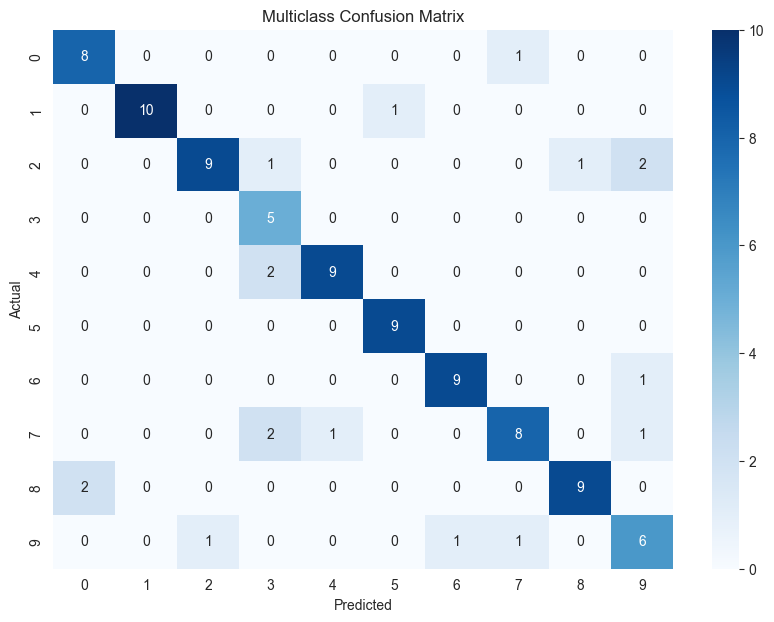

In [355]:
plot_confusion_matrix(clip_summary['pred'], clip_summary['true'], labels=y_test_segments.unique())

In [356]:
print(classification_report(y_true=clip_summary['true'], y_pred=clip_summary['pred']))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.91      1.00      0.95        10
           2       0.69      0.90      0.78        10
           3       1.00      0.50      0.67        10
           4       0.82      0.90      0.86        10
           5       1.00      0.90      0.95        10
           6       0.90      0.90      0.90        10
           7       0.67      0.80      0.73        10
           8       0.82      0.90      0.86        10
           9       0.67      0.60      0.63        10

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



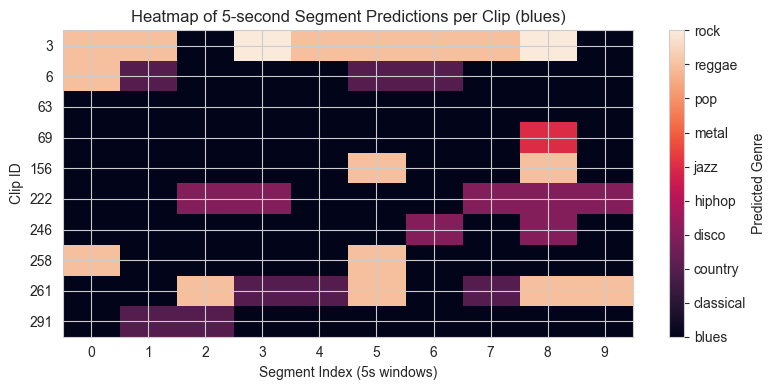

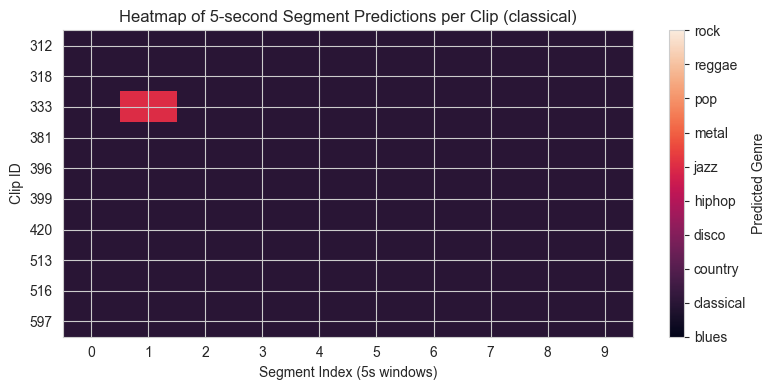

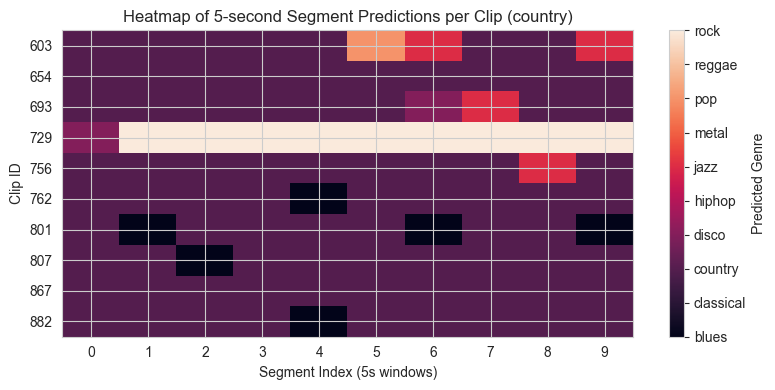

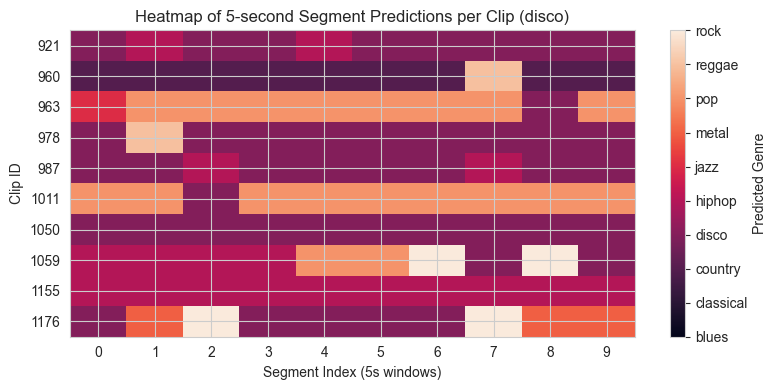

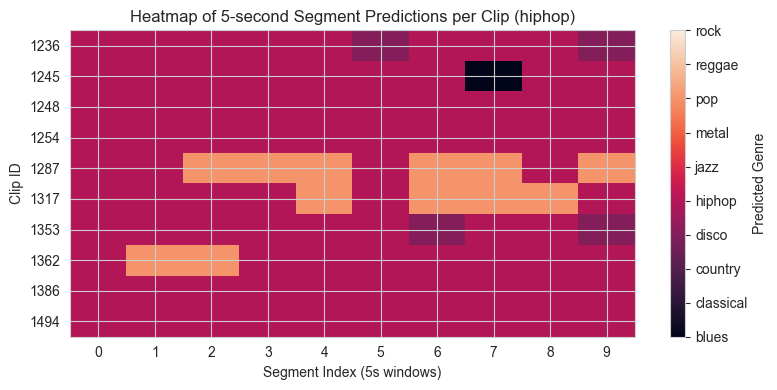

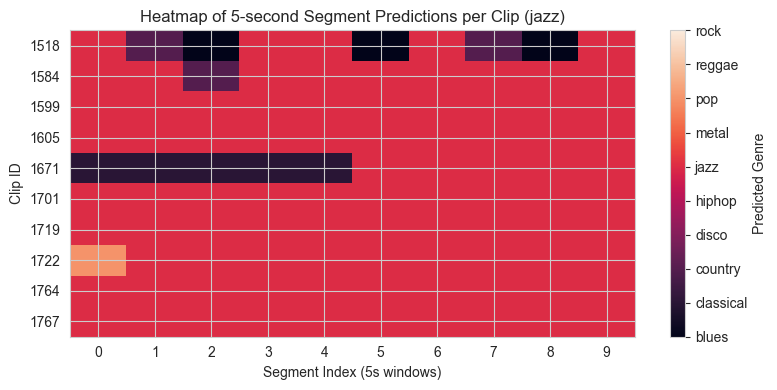

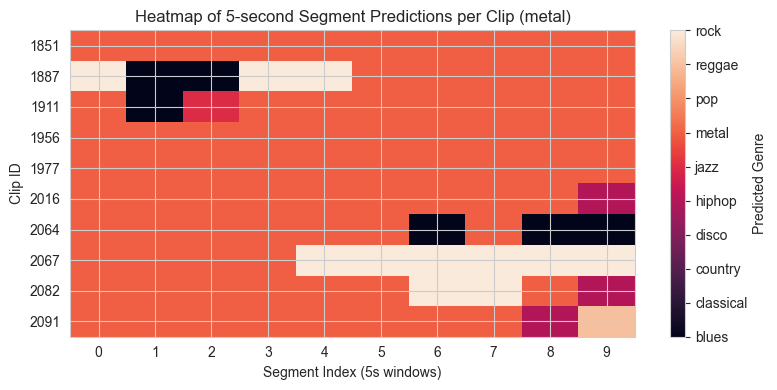

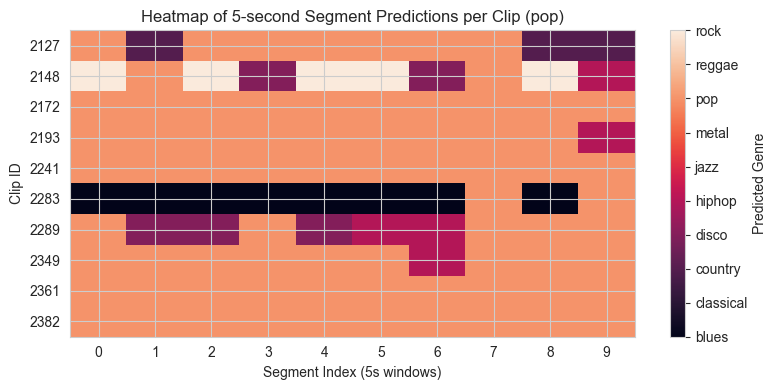

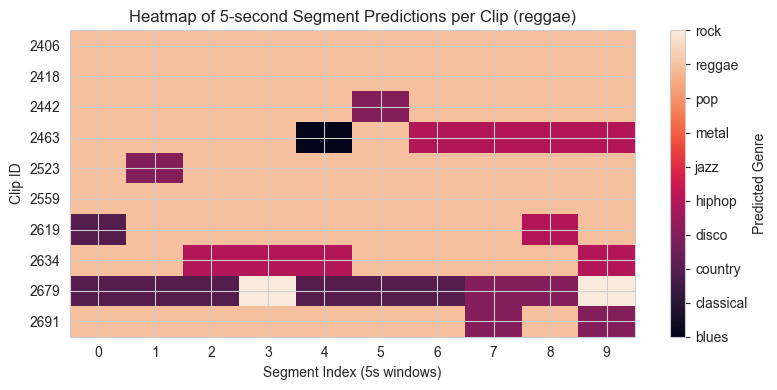

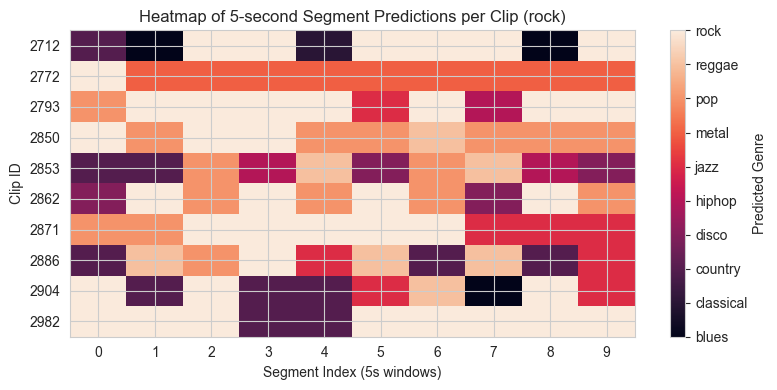

In [357]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0, 10):
    pivot = (
        test_df[test_df['genre_idx']==i]
        .pivot(index='clip_id', columns='segment_id', values='pred_seg')
        .sort_index()
        .sort_index(axis=1)
    )
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(pivot.values, aspect='auto', vmin=0, vmax=9)
    
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    
    label = le.inverse_transform([i])
    
    ax.set_xlabel('Segment Index (5s windows)')
    ax.set_ylabel('Clip ID')
    ax.set_title(f'Heatmap of 5-second Segment Predictions per Clip ({label[0]})')
    
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(10))
    cbar.ax.set_yticklabels(le.inverse_transform(np.arange(10)))
    cbar.set_label('Predicted Genre')
    
    plt.tight_layout()
    plt.show()

In [402]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow import keras

X_train_scaled = X_train_scaled.astype(np.float32)

input_shape = X_train_scaled.shape[1:]
num_classes = len(y_test_segments.unique())

model = Sequential([
    Dense(5),
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [403]:
y_train_categorical = utils.to_categorical(y_train, num_classes=10)
y_valid_categorical = utils.to_categorical(y_valid, num_classes=10)
y_test_categorical = utils.to_categorical(y_test_segments, num_classes=10)

history = model.fit(
    X_train_scaled, np.array(y_train_categorical),
    epochs=50, batch_size=512, verbose=1, validation_data=(X_valid_scaled, np.array(y_valid_categorical)),
)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

y_pred = model.predict(X_test).argmax(axis=1)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1037 - loss: 2.3143 - val_accuracy: 0.1400 - val_loss: 2.2607
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1879 - loss: 2.2158 - val_accuracy: 0.1911 - val_loss: 2.1903
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 2.1254 - val_accuracy: 0.2022 - val_loss: 2.1113
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2890 - loss: 2.0212 - val_accuracy: 0.2378 - val_loss: 2.0289
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3105 - loss: 1.9235 - val_accuracy: 0.2667 - val_loss: 1.9497
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3328 - loss: 1.8393 - val_accuracy: 0.2733 - val_loss: 1.8869
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3514 - loss: 1.7705 - val_accuracy: 0.2889 - val_loss: 1.8322
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3753 - loss: 1.7179 - val_accuracy: 0.3111 - val_loss:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       1.00      0.11      0.20       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.10      1.00      0.18       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100

    accuracy                           0.11      1000
   macro avg       0.11      0.11      0.04      1000
weighted avg       0.11      0.11      0.04      1000



C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

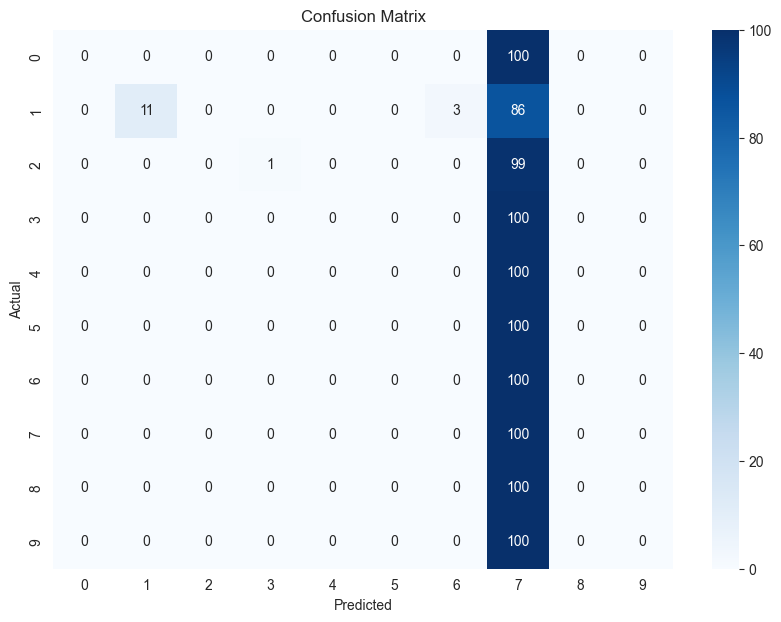

In [404]:
print(classification_report(y_test_segments, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_segments, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test_segments.unique(), yticklabels=y_test_segments.unique(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()